In [1]:
from autocnet.matcher import subpixel as sp
from autocnet.transformation import homography as hg
from plio.io.io_gdal import GeoDataset

import affine
import sys
import gdal
from osgeo import ogr
import json
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setup the paths to cubes and tiffs
cub_image1 = "/Volumes/Blueman/HiRISE_Jezero/ESP_023379_1985_1m_o_isis3.cub"
cub_image2 = "/Volumes/Blueman/HiRISE_Jezero/ESP_048908_1985_1m_o_isis3.cub"
cub_image3 = "/Volumes/Blueman/HiRISE_Jezero/DEM_1m_Jezero_C_isis3.cub"

tiff_image1 = "/Volumes/Blueman/HiRISE_Jezero/ESP_023379_1985_1m_o_isis3.tiff"
tiff_image2 = "/Volumes/Blueman/HiRISE_Jezero/ESP_048908_1985_1m_o_isis3.tiff"

# Define the resample type used by the warp command
resample = 'bilinear'

# Uncomment on first run as you will want to the tiffs
gdal.Warp(tiff_image1, cub_image1, resampleAlg=resample)
gdal.Warp(tiff_image2, cub_image2, resampleAlg=resample)

# Get all geo data for the two co-registered tiffs
geo1 = GeoDataset(tiff_image1)
geo2 = GeoDataset(tiff_image2)

# Setup and redefine all 0 values as NaNs
arr_image1 = geo1.read_array(1)
arr_image1[arr_image1 == 0] = np.NAN

arr_image2 = geo2.read_array(1)
arr_image2[arr_image2 == 0] = np.NAN

In [3]:
# Plot the images and there overlapping grid area
def show_initial_coregistration(geo_source, geo_destination, source_image, destination_image):
    ul1, lr1 = geo1.latlon_extent
    min_lon1, max_lon1, min_lat1, max_lat1 = lr1[0], ul1[0], ul1[1], lr1[1]

    ul2, lr2 = geo2.latlon_extent
    min_lon2, max_lon2, min_lat2, max_lat2 = lr2[0], ul2[0], ul2[1], lr2[1]

    plt.figure(0, figsize=(10, 10))
    plt.imshow(arr_image1, extent=[min_lat1, max_lat1, min_lon1, max_lon1], alpha=.5, cmap='Greys')
    plt.imshow(arr_image2, extent=[min_lat2, max_lat2, min_lon2, max_lon2], alpha=.5, cmap='Greys')
    plt.show()

# Show the quiver plot of the offsets
def display_quiver(comp_df, source_image, mask = [], scale = 100, scale_units = 'inches', **kwargs):
    if len(mask) != 0:
        comp_df = comp_df[mask]
    
    plt.figure(4, figsize=(20, 20))
    plt.imshow(source_image, cmap="Greys")
    plt.quiver(comp_df['destination_x'], comp_df['destination_y'], 
               -(comp_df['xoff']), (comp_df['yoff']),
               color = 'Red', scale = scale, scale_units = scale_units, **kwargs)
    plt.show()
    
# Given an index in the dataframe examine the before and after
# when the offset is applied
def examine_point(idx, size, comp_df, source_image, destination_image, mask = []):
    if len(mask) != 0:
        comp_df = comp_df[mask]
        
    plt.figure(2, figsize=(5, 5))
    plt.text(20, 50, 'Before Offset Correction', fontsize=12)
    x, y = int(comp_df.iloc[idx]['source_x']), int(comp_df.iloc[idx]['source_y'])
    plt.imshow(source_image[y - size:y + size, x - size:x + size], alpha = .5, cmap='Greys')

    x, y = int(comp_df.iloc[idx]['destination_x']), int(comp_df.iloc[idx]['destination_y'])
    plt.imshow(destination_image[y - size:y + size, x - size:x + size], alpha = .5, cmap='Greys')

    plt.figure(3, figsize=(5, 5))
    plt.text(20, 50, 'After Offset Correction', fontsize=12)
    x, y = int(comp_df.iloc[idx]['offset_source_x']), int(comp_df.iloc[idx]['offset_source_y'])
    plt.imshow(source_image[y - size: y + size, x - size: x + size], alpha = .5, cmap='Greys')

    x, y = int(comp_df.iloc[idx]['destination_x']), int(comp_df.iloc[idx]['destination_y'])
    plt.imshow(destination_image[y - size:y + size, x - size:x + size], alpha = .5, cmap='Greys')
    plt.show()
    
    offset_x, offset_y, corr = comp_df.iloc[idx][['xoff', 'yoff', 'corr']]
    print('X Offset: {}\nY Offset: {}\nCorrelation: {}'.format(offset_x, offset_y, corr))
    
def compute_homography(comp_df):
    x1 = np.array([*zip(comp_df['offset_source_x'].__array__(), comp_df['offset_source_y'].__array__())])
    x2 = np.array([*zip(comp_df['destination_x'].__array__(), comp_df['destination_y'].__array__())])
    H, mask = hg.compute_homography(x1, x2)
    
    return H, mask

# Apply the homography to the source image and display
def apply_homography(comp_df, source_image, destination_image):
    H,mask = compute_homography(comp_df)

    w, h = source_image.shape
    result = cv2.warpPerspective(source_image, H, (h, w))
    result[result == 0] = np.NAN

    plt.figure(0, figsize=(20, 20))
    plt.imshow(result, cmap='Greys', alpha = .5)
    plt.imshow(destination_image, cmap='Greys', alpha = .5)
    
def generate_point_grid(geo_source, geo_destination, size):
    # Get the lat lon corners
    lat1 = [i[0] for i in geo1.latlon_corners]
    lon1 = [i[1] for i in geo1.latlon_corners]

    # Compute a ogr geometry for the tiff which
    # provides leverage for overlaps
    ring1 = ogr.Geometry(ogr.wkbLinearRing)
    for point in [*zip(lon1, lat1)]:
        ring1.AddPoint(*point)
    ring1.AddPoint(lon1[0], lat1[0])

    poly1 = ogr.Geometry(ogr.wkbPolygon)
    poly1.AddGeometry(ring1)
    footprint1 = poly1
    
    # Do the same for the next geom
    lat2 = [i[0] for i in geo2.latlon_corners]
    lon2 = [i[1] for i in geo2.latlon_corners]

    ring2 = ogr.Geometry(ogr.wkbLinearRing)
    for point in [*zip(lon2, lat2)]:
        ring2.AddPoint(*point)
    ring2.AddPoint(lon2[0], lat2[0])

    poly2 = ogr.Geometry(ogr.wkbPolygon)
    poly2.AddGeometry(ring2)
    footprint2 = poly2

    # Set the footprint to a basic bounding
    geo1._footprint = footprint1
    geo2._footprint = footprint2

    # Compute the overlap and get the corners now that
    # we have the geometry
    overlap_hull = geo1.compute_overlap(geo2)[0]

    # Get the lats and lons of the assocaited corners
    overlap_lon = [i[0] for i in overlap_hull]
    overlap_lat = [i[1] for i in overlap_hull]

    # Reset the footprints to null so they aren't used
    # later on
    geo1._footprint = None
    geo2._footprint = None

    # Define a ratio so the distrabution is even
    overlap_ratio = (max(overlap_lon) - min(overlap_lon)) / (max(overlap_lat) - min(overlap_lat))

    lon = np.linspace(min(overlap_lon) + .001, max(overlap_lon) - .001, size)
    lat = np.linspace(min(overlap_lat) + .001, max(overlap_lat) - .001, round(size/overlap_ratio))
    print('Generateing', len(lon), 'by', len(lat), 'point grid.')

    # Get the lat, lon position for the grid
    lonv, latv = np.meshgrid(lon, lat, sparse=True)

    coords = []

    # Begin looping over each point in the grid
    for lat_val in latv:
        for lon_val in lonv[0]:
            # Find the point in pixel space for each image and get the value
            x1, y1  = geo1.latlon_to_pixel(lat_val[0], lon_val)
            x2, y2  = geo2.latlon_to_pixel(lat_val[0], lon_val)
            point_val1 = arr_image1[y1 - 1, x1 - 1]
            point_val2 = arr_image2[y2 - 1, x2 - 1]

            # If either is zero then the point should be ignored
            # as it lies outside of the true overlap
            if point_val1 > 0 and point_val2 > 0:
                coords.append([x1, y1, x2, y2, lat_val[0], lon_val])

    # Build dataframe after grid contruction for data storage and 
    # ease of access
    df = pd.DataFrame(coords, columns = ['source_x', 
                                         'source_y', 
                                         'destination_x', 
                                         'destination_y', 
                                         'lat', 
                                         'lon'])
    return df

# The Meat and Potatoes of offset calculation
def compute_offsets(df, source_geo, destination_geo, template_size, search_size):
    # Define a template size and a search space size
    s_img = source_geo

    d_img = destination_geo

    offsets = []

    # Iterate through each point in the dataframe and calculate offsets
    print('Computing Offsets')
    for idx, row in df.iterrows():

        x, y = row['source_x'], row['source_y']
        s_template = sp.clip_roi(s_img, (x, y), template_size)


        x, y = row['destination_x'], row['destination_y']
        d_search = sp.clip_roi(d_img, (x, y), search_size)

        xoff, yoff, corr = sp.subpixel_offset(s_template, d_search)
        xoff, yoff, corr = int(xoff),int(yoff),corr
        # Apply the offsets to the source points and 
        # save those as well
        offset_source_x = row['source_x'] - xoff
        offset_source_y = row['source_y'] + yoff
        offsets.append([offset_source_x, offset_source_y, xoff, yoff, corr])
        sys.stdout.write('%s%s\r' % (round((idx/len(df) * 100)), '% complete'))
        sys.stdout.flush()
        
    off_df = pd.DataFrame(offsets, columns = ['offset_source_x', 'offset_source_y', 'xoff', 'yoff', 'corr'])
    comp_df = df.merge(off_df, left_index=True, right_index=True)

    H, mask = compute_homography(comp_df)
    return comp_df, H, mask

In [4]:
# Generate a dataframe of points associated with a grid where each point
# in the grid is seperated by 
df = generate_point_grid(geo1, geo2, 20)
comp_df, H, mask = compute_offsets(df, geo1, geo2, 25, 101)

Generateing 20 by 30 point grid.
Computing Offsets


In [5]:
comp_df[['xoff', 'yoff', 'corr']].describe()

,xoff,yoff,corr
count,363.000000,363.000000,363.000000
mean,18.432507,-25.438017,0.907140
std,10.816028,6.940822,0.066393
min,-37.000000,-35.000000,0.547907
25%,10.000000,-29.000000,0.885901
50%,20.000000,-26.000000,0.923984
75%,28.000000,-22.000000,0.946759
max,37.000000,38.000000,1.000000


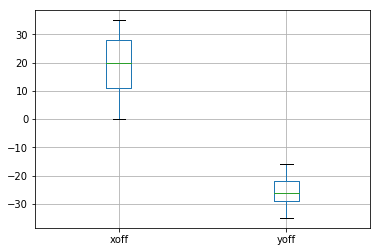

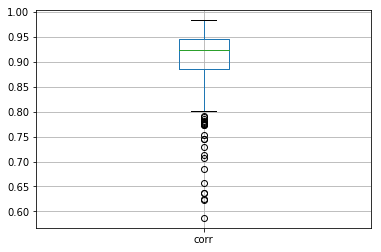

In [6]:
plt.figure(0)
comp_df[mask].boxplot(['xoff', 'yoff'], figsize=(10, 10))

plt.figure(1)
comp_df[mask].boxplot('corr', figsize=(10, 10))

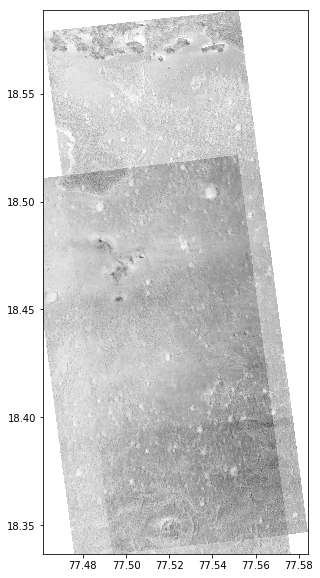

In [7]:
show_initial_coregistration(geo1, geo2, arr_image1, arr_image2)

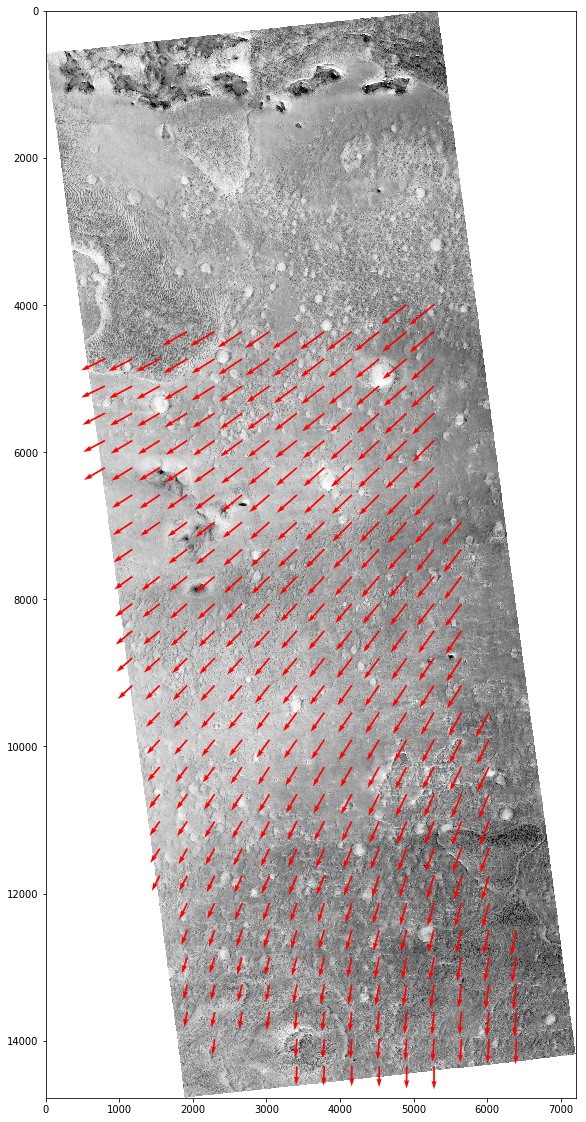

In [8]:
display_quiver(comp_df, arr_image2, mask = mask, scale = 100)

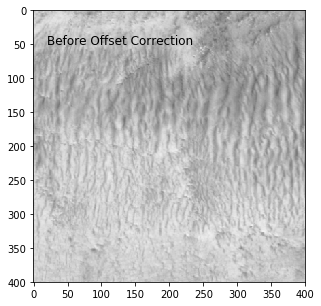

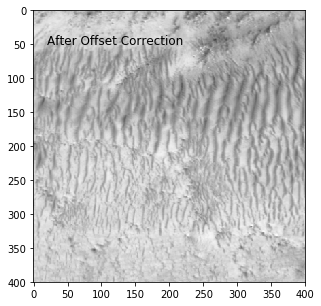

X Offset: 1.0
Y Offset: -26.0
Correlation: 0.9637669920921326


In [9]:
examine_point(0, 200, comp_df, arr_image1, arr_image2, mask = mask)

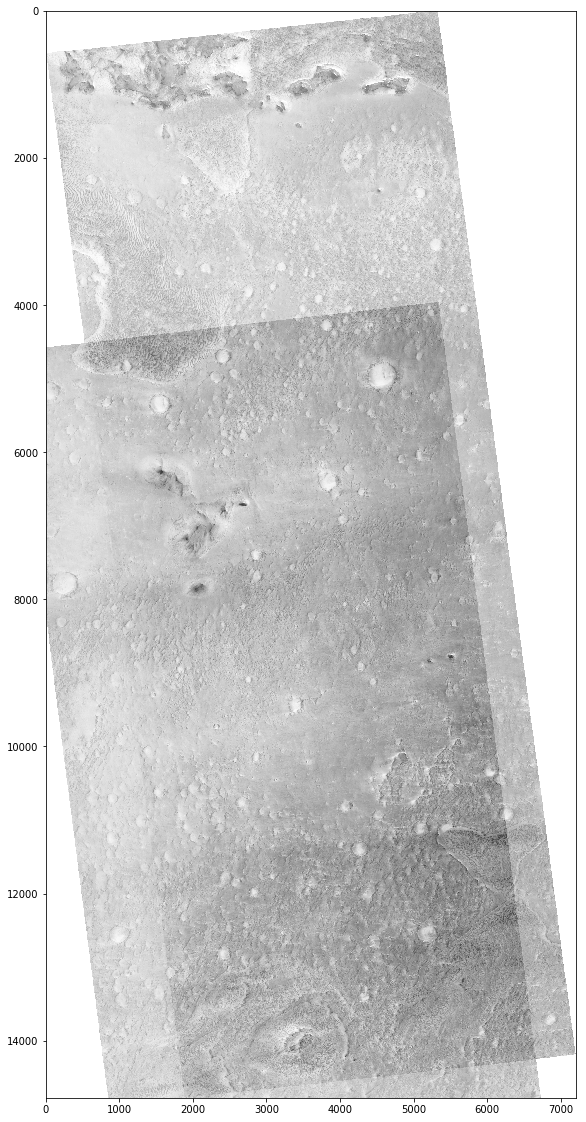

In [10]:
apply_homography(comp_df, arr_image1, arr_image2)